## Orlando OPD Crime Analysis - Update: 01/19/2022

* Updates Note
    * Jan 20, 2022 (planned) 
        * 3. Data Wrangling - 4) Join data (spatial), prepare census data
        * Solve conda install --- error
    * Jan 19, 2022
        * Develop and re-organize analysis process
        * 3. Data Wrangling - 1) Read CSV, 2) Check data, 3) Clean data
    * Jan 18. 2022
        * Develop datetime analysis and create three plots

### 1. Configuration

In [34]:
# Import Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('classic')
import json
import csv
from arcpy import env
from arcgis.gis import GIS
from arcgis.features import SpatialDataFrame
from arcgis.geocoding import geocode
from arcgis.geometry import lengths, areas_and_lengths, project, Point, Polyline, Polygon, Geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.geoprocessing import import_toolbox
from datetime import datetime
from datetime import datetime
from dateutil import parser

# conda install seaborn
# conda install geopandas
# install geopandas as gpd

In [28]:
# LOG-IN TO ARCGIS ONLINE
gis = GIS("https://www.arcgis.com", "kjhoon", "Apotheosis3267!")

### 2. Sharing the spatially-enabled dataframe on the webs

In [3]:
# CREATE BASEMAP
map1 = gis.map('Orlando, FL', 13)
map1.basemap = "satellite"
map1

MapView(layout=Layout(height='400px', width='100%'))

In [4]:
# IMPORT CSV & GET SUMMARY INFO OF DF
crime_df = pd.read_csv(r'C:/Users/KIM36105/Downloads/OPD_Crimes.csv')
crime_df1 = crime_df
crime_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238491 entries, 0 to 238490
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Case Number                 238491 non-null  object
 1   Case Date Time              238489 non-null  object
 2   Case Location               238491 non-null  object
 3   Case Offense Location Type  238491 non-null  object
 4   Case Offense Category       238491 non-null  object
 5   Case Offense Type           238491 non-null  object
 6   Case Offense Charge Type    238491 non-null  object
 7   Case Disposition            238491 non-null  object
 8   Status                      238491 non-null  object
 9   Location                    228265 non-null  object
dtypes: object(10)
memory usage: 18.2+ MB


In [5]:
# CHECK DF
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location
0,2020-00000700,01/01/2020 03:44:00 PM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN
1,2019-00002818,01/03/2019 08:22:00 AM,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"(28.60235426, -81.43691172)"
2,2020-00004890,01/05/2020 09:48:00 AM,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN
3,2020-00007368,01/07/2020 01:04:00 PM,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"(28.60018728, -81.45147832)"
4,2020-00008073,01/08/2020 01:18:00 AM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN


In [6]:
# REMOVE UNNECESSARY STRINGS IN COORDINATE COLUMN
crime_df1['Location'] = crime_df['Location'].str.replace("(","")
crime_df1['Location'] = crime_df['Location'].str.replace(")","")
crime_df1.head()

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location
0,2020-00000700,01/01/2020 03:44:00 PM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN
1,2019-00002818,01/03/2019 08:22:00 AM,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172"
2,2020-00004890,01/05/2020 09:48:00 AM,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN
3,2020-00007368,01/07/2020 01:04:00 PM,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832"
4,2020-00008073,01/08/2020 01:18:00 AM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN


In [7]:
# CREATE SEPARTE COLUMNS FOR LATITUDE AND LONGITUDE
lat = []
lon = []

for row in crime_df1['Location']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)

crime_df1['Latitude'] = lat
crime_df1['Longitude'] = lon
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Latitude,Longitude
0,2020-00000700,01/01/2020 03:44:00 PM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN,NaN,NaN
1,2019-00002818,01/03/2019 08:22:00 AM,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",28.60235426,-81.43691172
2,2020-00004890,01/05/2020 09:48:00 AM,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN
3,2020-00007368,01/07/2020 01:04:00 PM,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",28.60018728,-81.45147832
4,2020-00008073,01/08/2020 01:18:00 AM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN


In [8]:
# CREATE SEPARATE COLUMNS FOR DAY MONTH YEAR
crime_df1['Case Date Time'] = pd.to_datetime(crime_df1['Case Date Time'], format = '%m/%d/%Y %I:%M:%S %p')
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Latitude,Longitude
0,2020-00000700,2020-01-01 15:44:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN,NaN,NaN
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",28.60235426,-81.43691172
2,2020-00004890,2020-01-05 09:48:00,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",28.60018728,-81.45147832
4,2020-00008073,2020-01-08 01:18:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN


In [9]:
# CREATE SEPARATE COLUMNS FOR YEAR, MONTH, DAY
crime_df1['Year'] = pd.DatetimeIndex(crime_df1['Case Date Time']).year
crime_df1['Month'] = pd.DatetimeIndex(crime_df1['Case Date Time']).month
crime_df1['Day'] = pd.DatetimeIndex(crime_df1['Case Date Time']).day
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Latitude,Longitude,Year,Month,Day
0,2020-00000700,2020-01-01 15:44:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN,NaN,NaN,2020.0,1.0,1.0
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",28.60235426,-81.43691172,2019.0,1.0,3.0
2,2020-00004890,2020-01-05 09:48:00,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,2020.0,1.0,5.0
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",28.60018728,-81.45147832,2020.0,1.0,7.0
4,2020-00008073,2020-01-08 01:18:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,2020.0,1.0,8.0


In [10]:
# DEFINE THE COLUMNS AS INTEGER 
crime_df1['Year'] = crime_df1['Year'].fillna(0)
crime_df1['Year'] = crime_df1['Year'].astype(int)
crime_df1['Month'] = crime_df1['Month'].fillna(0)
crime_df1['Month'] = crime_df1['Month'].astype(int)
crime_df1['Day'] = crime_df1['Day'].fillna(0)
crime_df1['Day'] = crime_df1['Day'].astype(int)
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Latitude,Longitude,Year,Month,Day
0,2020-00000700,2020-01-01 15:44:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN,NaN,NaN,2020,1,1
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",28.60235426,-81.43691172,2019,1,3
2,2020-00004890,2020-01-05 09:48:00,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,2020,1,5
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",28.60018728,-81.45147832,2020,1,7
4,2020-00008073,2020-01-08 01:18:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,2020,1,8


In [11]:
# CHEKC THE SUMMARY OF DATA
crime_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238491 entries, 0 to 238490
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Case Number                 238491 non-null  object        
 1   Case Date Time              238489 non-null  datetime64[ns]
 2   Case Location               238491 non-null  object        
 3   Case Offense Location Type  238491 non-null  object        
 4   Case Offense Category       238491 non-null  object        
 5   Case Offense Type           238491 non-null  object        
 6   Case Offense Charge Type    238491 non-null  object        
 7   Case Disposition            238491 non-null  object        
 8   Status                      238491 non-null  object        
 9   Location                    228265 non-null  object        
 10  Latitude                    228265 non-null  object        
 11  Longitude                   228265 non-

In [12]:
# CREATE SUBSET WITH 2020 YEAR
crime_df1_2020 = crime_df1.loc[:][crime_df1['Year'] == 2020]
crime_df1_2020.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Latitude,Longitude,Year,Month,Day
0,2020-00000700,2020-01-01 15:44:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN,NaN,NaN,2020,1,1
2,2020-00004890,2020-01-05 09:48:00,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,2020,1,5
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",28.60018728,-81.45147832,2020,1,7
4,2020-00008073,2020-01-08 01:18:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,2020,1,8
12,2020-00022339,2020-01-19 02:51:00,3200 Block of S SEMORAN BLVD,Highway/Road/Alley,Assault,Simple assault,Committed,Inactive,Mapped,"28.51083543, -81.31031512",28.51083543,-81.31031512,2020,1,19


In [13]:
# READ INTO SPATIALLY ENABLED DATAFRAME SEDF
crime_sedf1_2020 = pd.DataFrame.spatial.from_xy(crime_df1_2020, 'Longitude', 'Latitude')
crime_sedf1_2020.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Latitude,Longitude,Year,Month,Day,SHAPE
0,2020-00000700,2020-01-01 15:44:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN,NaN,NaN,2020,1,1,"{""spatialReference"": {""wkid"": 4326}, ""x"": NaN,..."
2,2020-00004890,2020-01-05 09:48:00,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,2020,1,5,"{""spatialReference"": {""wkid"": 4326}, ""x"": NaN,..."
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",28.60018728,-81.45147832,2020,1,7,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
4,2020-00008073,2020-01-08 01:18:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,2020,1,8,"{""spatialReference"": {""wkid"": 4326}, ""x"": NaN,..."
12,2020-00022339,2020-01-19 02:51:00,3200 Block of S SEMORAN BLVD,Highway/Road/Alley,Assault,Simple assault,Committed,Inactive,Mapped,"28.51083543, -81.31031512",28.51083543,-81.31031512,2020,1,19,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."


In [14]:
# Plot the Crime SDEF and Check it
crime_sedf1_2020.spatial.plot(map1)

True

In [15]:
# Export to ArcGIS Online Repository
Orlando_Crime = crime_sedf1_2020.spatial.to_featurelayer('Orlando_Crimes_2020')
Orlando_Crime

<Item title:"Orlando_Crimes_2020" type:Feature Layer Collection owner:kjhoon>

### 3. Data Wrangling

#### 1) Read CSV via different sources

In [73]:
# A. Read csv from the JSON API
crime_df0 =pd.read_json(r'https://data.cityoforlando.net/resource/4y9m-jbmz.json')
crime_df0.head()

,case_number,case_date_time,case_location,case_offense_location,case_offense_category,case_offense_type,case_offense_charge_type,case_deposition,status,location,:@computed_region_bgqw_styj,:@computed_region_gsfg_ku74,:@computed_region_u8wz_9eai
0,2020-00000700,2020-01-01 15:44:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN,NaN,NaN,NaN
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"{'latitude': '28.60235426', 'longitude': '-81....",4.0,22.0,NaN
2,2020-00004890,2020-01-05 09:48:00,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,NaN
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"{'latitude': '28.60018728', 'longitude': '-81....",NaN,NaN,NaN
4,2020-00008073,2020-01-08 01:18:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,NaN


In [74]:
# B. Read csv from the local drive
crime_df1 = pd.read_csv(r'C:/Users/KIM36105/Downloads/OPD_Crimes.csv')
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location
0,2020-00000700,01/01/2020 03:44:00 PM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN
1,2019-00002818,01/03/2019 08:22:00 AM,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"(28.60235426, -81.43691172)"
2,2020-00004890,01/05/2020 09:48:00 AM,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN
3,2020-00007368,01/07/2020 01:04:00 PM,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"(28.60018728, -81.45147832)"
4,2020-00008073,01/08/2020 01:18:00 AM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN


In [38]:
# C. Read csv from Cloud Database using SQL (IBM DB2)

# Service Credentials
# "username": "gtr22671"
# "password": "yeTtnClz98DSRKWv"
# "hostname": "55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud"
# "port": 31929
# "database": "bludb"

#### 2) Check data structure and types & plan analysis process

In [85]:
# Check the dataframe fields briefly 
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"(28.60235426, -81.43691172)"
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"(28.60018728, -81.45147832)"
6,2019-00011880,2019-01-09 20:17:00,1900 Block of CONWAY RD,Apartment/Condo,Assault,Simple assault,Committed,Inactive,Mapped,"(28.51715097, -81.33099064)"
12,2020-00022339,2020-01-19 02:51:00,3200 Block of S SEMORAN BLVD,Highway/Road/Alley,Assault,Simple assault,Committed,Inactive,Mapped,"(28.51083543, -81.31031512)"
18,2020-00037177,2020-01-31 08:10:00,500 Block of N JOHN YOUNG PKWY,Bus/Rail Terminal,Assault,Simple assault,Committed,Arrest,Mapped,"(28.54799721, -81.41373753)"


In [64]:
# Check the dataframe columns info
crime_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238491 entries, 0 to 238490
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Case Number                 238491 non-null  object
 1   Case Date Time              238489 non-null  object
 2   Case Location               238491 non-null  object
 3   Case Offense Location Type  238491 non-null  object
 4   Case Offense Category       238491 non-null  object
 5   Case Offense Type           238491 non-null  object
 6   Case Offense Charge Type    238491 non-null  object
 7   Case Disposition            238491 non-null  object
 8   Status                      238491 non-null  object
 9   Location                    228265 non-null  object
dtypes: object(10)
memory usage: 18.2+ MB


"Key Findings from the above information"

* 1) The crime datadrame dimension is 238491 (rows) x 10 (columns)
* 2) All columns types are object
* 3) The columns information can be categorized by the followings:
    * a. Primary Key  - "Case Number"
    * b. Time         - "Case Date Time"
    * c. Location     - "Case Location", "Case Offense Location Type", "Status", "Location"
    * d. Offense Info     - "Case Offense Category", "Case Offense Type", "Case Offense Charge Type", "Case Dispostion"



Regarding to the above dataframe information, we need to
  * 1) Remove null values from the columns (2 from "Case Date Time" and 10226 from "Location")
  * 2) Convert the "Case Date Time" datatypes from "object" to "datetime"
  * 3) Create new columns from the datetime column. 
  * 4) Create SEDF and do spatial-join the dataframe with other spatial data
      * a. ZipCode, Neighborhood
      * b. Census Data => Can be used for building a geospatial-prediction model
  * 5) Convert the DataFrame from Long to Wide.
  * 6) Analyze the datasets
      * a. Date Times
          * (1) Year-Month-Day
          * (2) Year-Month
          * (3) Day of Week
          * (4) Hours, AM/PM
      * b. Location
          * Neighborhoods
      * c. Offense Info
          * (1) Offnese Category
          * (2) Offense Type
  * 7) Building a regression model with Census Data
      * a. Linear Regression Model
      * b. Other Regression Model
      * c. Spatial Modeling


#### 3) Clean Data

In [76]:
# 1) Remove NA values in "Case Date Time" and "Location" columns.
crime_df1 = crime_df1.dropna(subset=['Case Date Time','Location'])
len(crime_df1.index)

# From the original, totla 10,226 cases removed.

228265

In [77]:
# 2) Convert "Case Date Time" data types from "object" to "datetime"

# To sillence SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Set the datetime frame to "Case Date Time"
crime_df1['Case Date Time'] = pd.to_datetime(crime_df1['Case Date Time'])
crime_df1.dtypes

Case Number                           object
Case Date Time                datetime64[ns]
Case Location                         object
Case Offense Location Type            object
Case Offense Category                 object
Case Offense Type                     object
Case Offense Charge Type              object
Case Disposition                      object
Status                                object
Location                              object
dtype: object

In [96]:
# 3) Create new columns from DateTime column
# Year, Month, Day Columns
crime_df1_time = crime_df1[:]
crime_df1_time['Date']       = crime_df1_time['Case Date Time'].dt.date
crime_df1_time['Time']       = crime_df1_time['Case Date Time'].dt.time
crime_df1_time['Year']       = crime_df1_time['Case Date Time'].dt.year
crime_df1_time['Month']      = crime_df1_time['Case Date Time'].dt.month
crime_df1_time['Hour']       = crime_df1_time['Case Date Time'].dt.hour
crime_df1_time['Weekday']    = crime_df1_time['Case Date Time'].dt.dayofweek

# Replace values in 'Weekday' column
crime_df1_time['Weekday'] = crime_df1_time['Weekday'].replace(
    [0, 1, 2, 3, 4, 5, 6],
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
crime_df1_time.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Date,Time,Year,Month,Hour,Weekday
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"(28.60235426, -81.43691172)",2019-01-03,08:22:00,2019,1,8,Thursday
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"(28.60018728, -81.45147832)",2020-01-07,13:04:00,2020,1,13,Tuesday
6,2019-00011880,2019-01-09 20:17:00,1900 Block of CONWAY RD,Apartment/Condo,Assault,Simple assault,Committed,Inactive,Mapped,"(28.51715097, -81.33099064)",2019-01-09,20:17:00,2019,1,20,Wednesday
12,2020-00022339,2020-01-19 02:51:00,3200 Block of S SEMORAN BLVD,Highway/Road/Alley,Assault,Simple assault,Committed,Inactive,Mapped,"(28.51083543, -81.31031512)",2020-01-19,02:51:00,2020,1,2,Sunday
18,2020-00037177,2020-01-31 08:10:00,500 Block of N JOHN YOUNG PKWY,Bus/Rail Terminal,Assault,Simple assault,Committed,Arrest,Mapped,"(28.54799721, -81.41373753)",2020-01-31,08:10:00,2020,1,8,Friday


In [97]:
# 4) Spatial-join with other spatial data

# First, remove from unnecessary strings from the Location column to separate longitued and latitude
crime_df1_time['Location'] = crime_df1_time['Location'].str.replace("(","")
crime_df1_time['Location'] = crime_df1_time['Location'].str.replace(")","")

# Create separate columns for Latitude and Longitude
lat = []
lon = []

for row in crime_df1_time['Location']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)

crime_df1_time['Latitude']  = lat
crime_df1_time['Longitude'] = lon
crime_df1_time.head()

D66140B0-0277-45FF-AE18-A787BE3D4AAF:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
D66140B0-0277-45FF-AE18-A787BE3D4AAF:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Date,Time,Year,Month,Hour,Weekday,Latitude,Longitude
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",2019-01-03,08:22:00,2019,1,8,Thursday,28.60235426,-81.43691172
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",2020-01-07,13:04:00,2020,1,13,Tuesday,28.60018728,-81.45147832
6,2019-00011880,2019-01-09 20:17:00,1900 Block of CONWAY RD,Apartment/Condo,Assault,Simple assault,Committed,Inactive,Mapped,"28.51715097, -81.33099064",2019-01-09,20:17:00,2019,1,20,Wednesday,28.51715097,-81.33099064
12,2020-00022339,2020-01-19 02:51:00,3200 Block of S SEMORAN BLVD,Highway/Road/Alley,Assault,Simple assault,Committed,Inactive,Mapped,"28.51083543, -81.31031512",2020-01-19,02:51:00,2020,1,2,Sunday,28.51083543,-81.31031512
18,2020-00037177,2020-01-31 08:10:00,500 Block of N JOHN YOUNG PKWY,Bus/Rail Terminal,Assault,Simple assault,Committed,Arrest,Mapped,"28.54799721, -81.41373753",2020-01-31,08:10:00,2020,1,8,Friday,28.54799721,-81.41373753


In [98]:
# Convert the dataframe into spatialy enabled dataframe
crime_sedf1 = pd.DataFrame.spatial.from_xy(crime_df1_time, 'Longitude', 'Latitude')
crime_sedf1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Date,Time,Year,Month,Hour,Weekday,Latitude,Longitude,SHAPE
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",2019-01-03,08:22:00,2019,1,8,Thursday,28.60235426,-81.43691172,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",2020-01-07,13:04:00,2020,1,13,Tuesday,28.60018728,-81.45147832,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
6,2019-00011880,2019-01-09 20:17:00,1900 Block of CONWAY RD,Apartment/Condo,Assault,Simple assault,Committed,Inactive,Mapped,"28.51715097, -81.33099064",2019-01-09,20:17:00,2019,1,20,Wednesday,28.51715097,-81.33099064,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
12,2020-00022339,2020-01-19 02:51:00,3200 Block of S SEMORAN BLVD,Highway/Road/Alley,Assault,Simple assault,Committed,Inactive,Mapped,"28.51083543, -81.31031512",2020-01-19,02:51:00,2020,1,2,Sunday,28.51083543,-81.31031512,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
18,2020-00037177,2020-01-31 08:10:00,500 Block of N JOHN YOUNG PKWY,Bus/Rail Terminal,Assault,Simple assault,Committed,Arrest,Mapped,"28.54799721, -81.41373753",2020-01-31,08:10:00,2020,1,8,Friday,28.54799721,-81.41373753,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."


#### 4) Join Data

In [ ]:
# Left - crime_sedf1 // Right - other spatially enabled data



In [21]:
# b-1. Total crime cases from 2010 to 2020
crime_Date_df1 = crime_analysis_df1.groupby(['Date']).size().reset_index().rename(columns={0: 'Crime Incidents'})
crime_Date_df1

,Date,Crime Incidents
0,2010-01-01,67
1,2010-01-02,44
2,2010-01-03,34
3,2010-01-04,68
4,2010-01-05,71
...,...,...
4013,2020-12-27,22
4014,2020-12-28,62
4015,2020-12-29,51
4016,2020-12-30,36


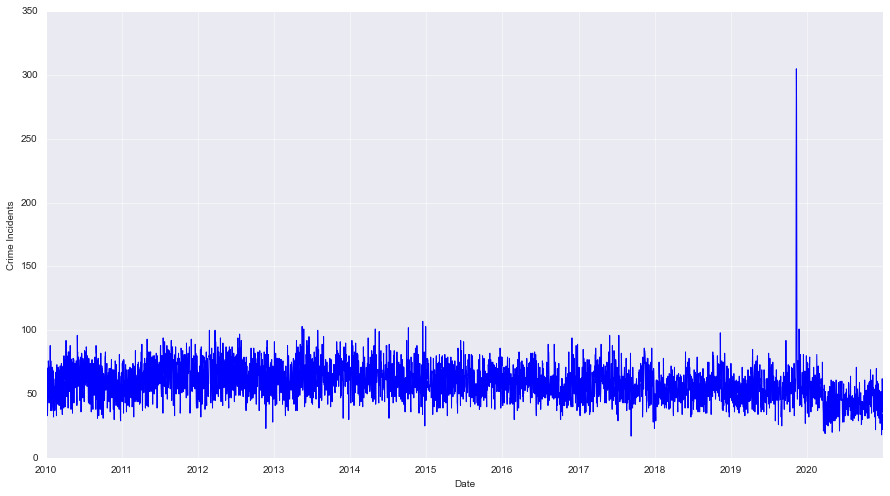

In [22]:
# Assign plot size
plt.figure(figsize = (15,8))

# Assign styles
sns.set_style("darkgrid")
pal = sns.color_palette('Set2', 12)

# Create line-plot
sns.lineplot(data=crime_Date_df1, 
             x="Date", y="Crime Incidents",
            palette=pal)

# Shows the plot
plt.show()

In [90]:
# b-2. Total crime cases by Case Offense Category from 2010 to 2020
crime_Date_df2 = crime_analysis_df1.groupby(['Date', 'Case Offense Category']).size().reset_index().rename(columns={0: 'Crime Incidents'})
crime_Date_df2.dtypes

NameError: name 'crime_analysis_df1' is not defined

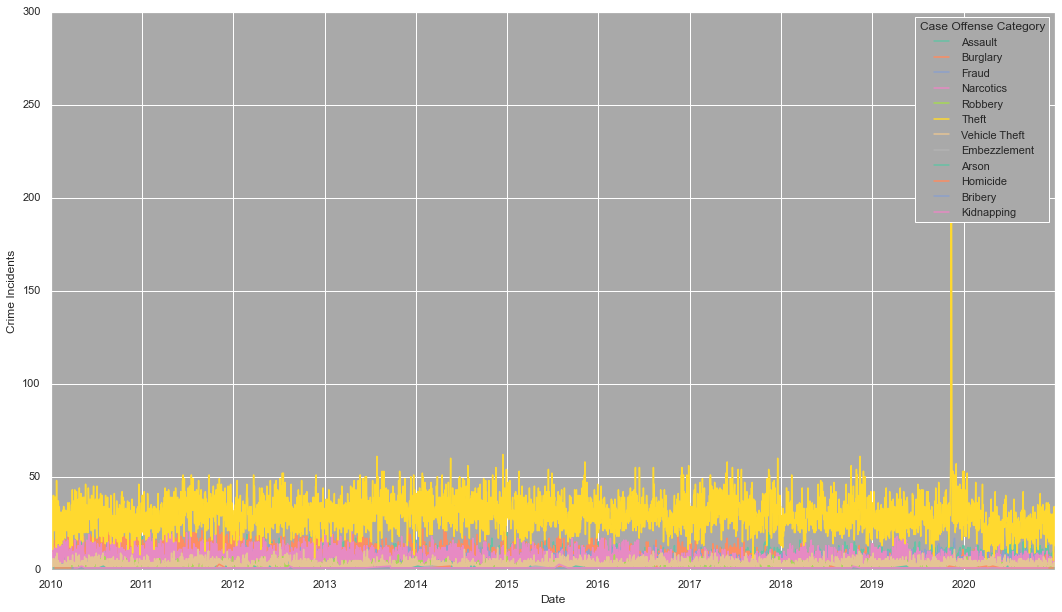

In [24]:
# Plot from 2010 to 2020
# Assign plot size
plt.figure(figsize = (18,10))

# Assign styles
sns.set_style("darkgrid")
pal = sns.color_palette('Set2', 12)
sns.set(rc={'axes.facecolor': 'darkgray'})

# Create line-plot
sns.lineplot(data=crime_Date_df2, 
             x="Date", y="Crime Incidents", hue='Case Offense Category',
            palette=pal)

# Shows the plot
plt.show()

In [25]:
# b-3. Create a subset Crime Data in 2020
crime_Date_df3 = crime_Date_df2
crime_Date_df3['Date'] = pd.to_datetime(crime_Date_df3['Date'])
crime_Date_df3 = crime_Date_df3.loc[crime_Date_df3['Date'].dt.year >= 2020]
crime_Date_df3.head()

,Date,Case Offense Category,Crime Incidents
24737,2020-01-01,Assault,13
24738,2020-01-01,Fraud,4
24739,2020-01-01,Narcotics,5
24740,2020-01-01,Theft,27
24741,2020-01-01,Vehicle Theft,2


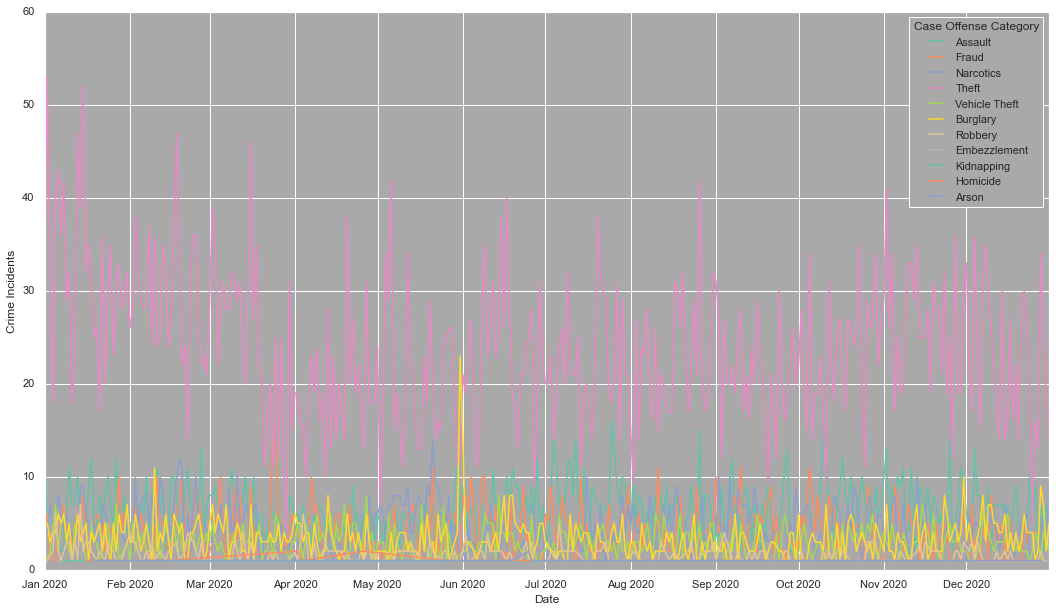

In [26]:
# Plot in 2020
# Assign plot size
plt.figure(figsize = (18,10))

# Assign styles
sns.set_style("whitegrid")
pal = sns.color_palette('Set2', 11)
sns.set(rc={'axes.facecolor': 'darkgray'})

# Create line-plot
sns.lineplot(data=crime_Date_df3, 
             x="Date", y="Crime Incidents", hue='Case Offense Category',
            palette=pal)

# Shows the plot
plt.show()

In [27]:
# Converted 
crime_Date_df3_1=crime_Date_df3.pivot(index='Date', columns='Case Offense Category', values='Crime Incidents').reset_index()
crime_Date_df3_1.head()

Case Offense Category,Date,Arson,Assault,Burglary,Embezzlement,Fraud,Homicide,Kidnapping,Narcotics,Robbery,Theft,Vehicle Theft
0,2020-01-01,NaN,13.0,NaN,NaN,4.0,NaN,NaN,5.0,NaN,27.0,2.0
1,2020-01-02,NaN,5.0,5.0,NaN,6.0,NaN,NaN,4.0,1.0,53.0,1.0
2,2020-01-03,NaN,5.0,3.0,NaN,2.0,NaN,NaN,7.0,NaN,33.0,2.0
3,2020-01-04,NaN,5.0,4.0,NaN,1.0,NaN,NaN,5.0,2.0,18.0,NaN
4,2020-01-05,NaN,5.0,4.0,NaN,1.0,NaN,NaN,6.0,6.0,40.0,7.0


In [28]:
# Theft
crime_Date_df3_2 = crime_Date_df3_1.loc[:, ['Date', 'Theft']].reset_index(drop=True).rename_axis('',axis=1).set_index('Date', drop=True)
crime_Date_df3_2.head()

,Theft
Date,
2020-01-01,27.0
2020-01-02,53.0
2020-01-03,33.0
2020-01-04,18.0
2020-01-05,40.0


<Figure size 576x1152 with 0 Axes>

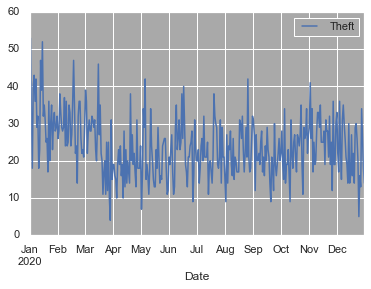

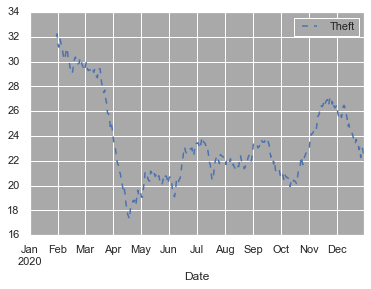

In [29]:
plt.figure(figsize=(8,16))

crime_Date_df3_2.plot()
crime_Date_df3_2.rolling(30).mean().plot(style='--');

plt.show()

In [30]:
crime_Date_df2['Date'] = pd.to_datetime(crime_Date_df2['Date'])
crime_Date_df2_1=crime_Date_df2.pivot(index='Date', columns='Case Offense Category', values='Crime Incidents').reset_index()
crime_Date_df2_1.head()

Case Offense Category,Date,Arson,Assault,Bribery,Burglary,Embezzlement,Fraud,Homicide,Kidnapping,Narcotics,Robbery,Theft,Vehicle Theft
0,2010-01-01,NaN,18.0,NaN,10.0,NaN,2.0,NaN,NaN,6.0,1.0,27.0,3.0
1,2010-01-02,NaN,2.0,NaN,5.0,NaN,3.0,NaN,NaN,1.0,2.0,29.0,2.0
2,2010-01-03,NaN,4.0,NaN,10.0,NaN,NaN,NaN,NaN,1.0,4.0,14.0,1.0
3,2010-01-04,NaN,6.0,NaN,11.0,NaN,4.0,NaN,NaN,3.0,3.0,40.0,1.0
4,2010-01-05,NaN,4.0,NaN,10.0,NaN,4.0,NaN,NaN,5.0,5.0,40.0,3.0


In [31]:
crime_Date_df2['Date'] = pd.to_datetime(crime_Date_df2['Date'])
crime_Date_df2_1=crime_Date_df2.pivot(index='Date', columns='Case Offense Category', values='Crime Incidents').reset_index()
crime_Date_df2_2 = crime_Date_df2_1.loc[:, ['Date', 'Theft']].reset_index(drop=True).rename_axis('',axis=1).set_index('Date', drop=True)
crime_Date_df2_2.head()

,Theft
Date,
2010-01-01,27.0
2010-01-02,29.0
2010-01-03,14.0
2010-01-04,40.0
2010-01-05,40.0


<Figure size 1440x720 with 0 Axes>

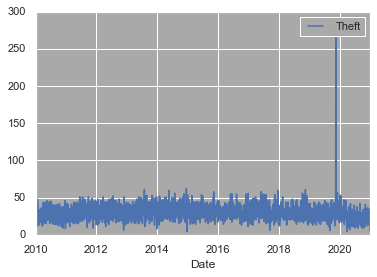

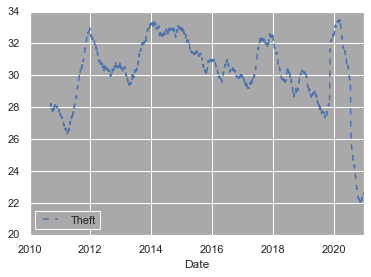

In [32]:
plt.figure(figsize=(20,10))

crime_Date_df2_2.plot()
crime_Date_df2_2.rolling(250).mean().plot(style='--');

plt.show()

In [ ]:
pip install censusdata
pip install census
pip install us

In [262]:
conda install censusdata
conda install census
conda install us

SyntaxError: invalid syntax (<string>, line 1)


EnvironmentLocationNotFound: Not a conda environment: C:\Program




Note: you may need to restart the kernel to use updated packages.


In [261]:
import census

ModuleNotFoundError: No module named 'census'

In [ ]:
c = Census("42e1b9b3b73ee4990e7c15500d52250286ba72cc")
c.acs5.get(('NAME', 'B25034_010E'),
          {'for': 'state:{}'.format(states.MD.fips)})

In [256]:
with open('census_key.txt') as key:
    api_key=key.read().strip()
 
year='2018'
dsource='pep'
dname='components'
cols='GEONAME,NATURALINC,DOMESTICMIG,INTERNATIONALMIG'
state='42'
county='017,029,045,091,101'

FileNotFoundError: [Errno 2] No such file or directory: 'census_key.txt'

import requests

HOST = "http://api.census.gov/data"
year = "2010"
dataset = "dec/sf1"
base_rul = "/".join([HOST, year, dataset])
predicates = {}
get_vars = ["NAME", "AREALAND", "P001001"]
predicates["get"] = ",".join(get_vars)
predicates["for"] = "state:*"
r = requests.get(base_url, params = predicates)

print(r.text)
print(r.json([0]))